In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [4]:
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(10,5)})

In [54]:
outgoing_query = """
		select
			case
				when company_deliveries.delivery_type = 'INCOMING_FROM_VENDOR' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'INCOMING_UNKNOWN' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'OUTGOING_UNKNOWN' then 'OUTGOING_TO_PAYOR'
				when company_deliveries.delivery_type = 'OUTGOING_TO_PAYOR' then 'OUTGOING_TO_PAYOR'
				else company_deliveries.delivery_type
			end as delivery_type,
			company_deliveries.license_number,
			metrc_transfers.manifest_number,
			metrc_transfers.created_date,
			metrc_deliveries.received_datetime,
			metrc_transfers.shipper_facility_license_number,
			metrc_transfers.shipper_facility_name,
			metrc_deliveries.recipient_facility_license_number,
			metrc_deliveries.recipient_facility_name,
			metrc_deliveries.shipment_type_name,
			metrc_deliveries.shipment_transaction_type,
			metrc_transfer_packages.package_id,
			metrc_transfer_packages.package_label,
			metrc_transfer_packages.type,
			metrc_transfer_packages.package_payload.sourcepackagelabels as source_package_labels,
			metrc_transfer_packages.package_payload.sourceharvestnames as source_harvest_names,
			metrc_transfer_packages.package_payload.shipmentpackagestate as shipment_package_state,
			metrc_transfer_packages.package_payload.istestingsample as is_testing_sample,
			metrc_transfer_packages.package_payload.istradesample as is_trade_sample,
			metrc_transfer_packages.product_category_name,
			metrc_transfer_packages.product_name,
			metrc_transfer_packages.lab_results_status as package_lab_results_status,
			metrc_transfer_packages.shipper_wholesale_price,
			metrc_transfer_packages.shipped_quantity,
			metrc_transfer_packages.shipped_unit_of_measure,
			metrc_transfer_packages.received_quantity,
			metrc_transfer_packages.received_unit_of_measure,
			metrc_transfer_packages.package_payload.receiverwholesaleprice as receiver_wholesale_price,
			metrc_transfer_packages.package_payload.itemunitweight as item_unit_weight,
			metrc_transfer_packages.package_payload.itemunitweightunitofmeasurename as item_unit_weight_unit_of_measure_name
		from
			metrc_transfers
			inner join company_deliveries on metrc_transfers.id = company_deliveries.transfer_row_id
			inner join companies on company_deliveries.company_id = companies.id
			inner join metrc_deliveries on metrc_transfers.id = metrc_deliveries.transfer_row_id
			inner join metrc_transfer_packages on metrc_deliveries.id = metrc_transfer_packages.delivery_row_id
		where
			True
			and (
				company_deliveries.delivery_type = 'OUTGOING_TO_PAYOR' or
				company_deliveries.delivery_type = 'OUTGOING_INTERNAL' or
				company_deliveries.delivery_type = 'OUTGOING_UNKNOWN'
			)
			and metrc_transfers.created_date >= "2020-01-01"
			
			
		--and company_deliveries.license_number in ('CDPH-10002402','C11-0001146-LIC','C11-0001255-LIC','CDPH-10004315','CDPH-10004690')
	 and company_deliveries.license_number in ('C11-0000127-LIC')
			
			
		order by
			metrc_transfers.created_date desc
            """

In [55]:
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(outgoing_query, engine)

In [56]:
company_outgoing_transfer_packages_dataframe['license_number'].unique()

array(['C11-0000127-LIC'], dtype=object)

In [57]:

df_out = company_outgoing_transfer_packages_dataframe

df_out['created_date'] = pd.to_datetime(df_out['created_date'])


In [58]:
df_out

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,received_quantity,received_unit_of_measure,receiver_wholesale_price,item_unit_weight,item_unit_weight_unit_of_measure_name
0,OUTGOING_TO_PAYOR,C11-0000127-LIC,0003801108,2022-07-23,NaT,C11-0000127-LIC,"INDUSTRIAL COURT L11, LLC",C11-0001071-LIC,"KDM HOLDINGS, LLC",Transfer,Standard,27269956,1A4060300003FB1000329784,transfer,1A4060300007671000001808,"1723B012622, 2.10 rm3.3, ACW HH1, B2 Viper 11/...",Shipped,False,False,Pre-Roll Infused,Littles Flaves-.5g Infused PreRoll-Melon Crush...,passed,151.2,48.0,Each,NaN,None,NaN,0.5,Grams
1,OUTGOING_TO_PAYOR,C11-0000127-LIC,0003801108,2022-07-23,NaT,C11-0000127-LIC,"INDUSTRIAL COURT L11, LLC",C11-0001071-LIC,"KDM HOLDINGS, LLC",Transfer,Standard,27269957,1A4060300003FB1000329779,transfer,1A406030004536E000002889,"1671L120721, 1706B011822, F15-15-13-2-10-0538,...",Shipped,False,False,Pre-Roll Infused,Jetpacks Hi Octane .5g Infused Pre-roll-Star P...,passed,151.2,48.0,Each,NaN,None,NaN,0.5,Grams
2,OUTGOING_TO_PAYOR,C11-0000127-LIC,0003801108,2022-07-23,NaT,C11-0000127-LIC,"INDUSTRIAL COURT L11, LLC",C11-0001071-LIC,"KDM HOLDINGS, LLC",Transfer,Standard,27269958,1A4060300003FB1000329782,transfer,1A406030004536E000002897,"01-10-2022 24 R5.T10 20018, 01-24-2022 24 R3.T...",Shipped,False,False,Pre-Roll Infused,Jetpacks Hi Octane .5g Infused PreRoll 5pk/12c...,passed,324.0,24.0,Each,NaN,None,NaN,2.5,Grams
3,OUTGOING_TO_PAYOR,C11-0000127-LIC,0003801108,2022-07-23,NaT,C11-0000127-LIC,"INDUSTRIAL COURT L11, LLC",C11-0001071-LIC,"KDM HOLDINGS, LLC",Transfer,Standard,27269954,1A4060300003FB1000329781,transfer,1A406030004536E000002895,"F16-1-0-0539, F16-11-0-2-14-0539, F16-11-12-14...",Shipped,False,False,Pre-Roll Infused,Jetpacks Hi Octane .5g Infused PreRoll 5pk/12c...,passed,324.0,24.0,Each,NaN,None,NaN,2.5,Grams
4,OUTGOING_TO_PAYOR,C11-0000127-LIC,0003801108,2022-07-23,NaT,C11-0000127-LIC,"INDUSTRIAL COURT L11, LLC",C11-0001071-LIC,"KDM HOLDINGS, LLC",Transfer,Standard,27270041,1A4060300003FB1000329778,transfer,1A406030004536E000002888,"CB-1-19-GLU-2638, CB-17-20-GLU-2676, CS-01-21-...",Shipped,False,False,Pre-Roll Infused,Jetpacks Hi Octane .5g Infused Pre-roll-Orange...,passed,151.2,48.0,Each,NaN,None,NaN,0.5,Grams
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177954,OUTGOING_TO_PAYOR,C11-0000127-LIC,0000227553,2020-01-02,2020-01-06 23:03:37+00:00,C11-0000127-LIC,"INDUSTRIAL COURT L11, LLC",C10-0000224-LIC,EAST OF EDEN CANNABIS COMPANY,Wholesale Manifest,Wholesale,1767308,1A4060300003FB1000022364,transfer,1A4060300003FB1000010243,,Accepted,False,False,Pre-Roll Flower,CRU X Littles 0.5g Pre-Roll - Pineapple Gelato,failed,500.0,200.0,Each,200.0,Each,500.0,0.5,Grams
177955,OUTGOING_TO_PAYOR,C11-0000127-LIC,0000227553,2020-01-02,2020-01-06 23:03:37+00:00,C11-0000127-LIC,"INDUSTRIAL COURT L11, LLC",C10-0000224-LIC,EAST OF EDEN CANNABIS COMPANY,Wholesale Manifest,Wholesale,1767293,1A4060300003FB1000022363,transfer,1A4060300003FB1000007962,,Accepted,False,False,Pre-Roll Flower,CRU Littles-.5g PreRoll-Green Crack,failed,500.0,200.0,Each,200.0,Each,500.0,0.5,Grams
177956,OUTGOING_TO_PAYOR,C11-0000127-LIC,0000227553,2020-01-02,2020-01-06 23:03:37+00:00,C11-0000127-LIC,"INDUSTRIAL COURT L11, LLC",C10-0000224-LIC,EAST OF EDEN CANNABIS COMPANY,Wholesale Manifest,Wholesale,1767291,1A4060300003FB1000022361,transfer,1A4060300003FB1000007964,,Accepted,False,False,Pre-Roll Flower,CRU X Littles 0.5g Pre-Roll - Tropicana Cookies,failed,500.0,200.0,Each,2

# 1. KIVA's outgoing to dispensaries

In [45]:
df_out[['delivery_type','package_id']].groupby('delivery_type').count()


,package_id
delivery_type,
OUTGOING_INTERNAL,3083
OUTGOING_TO_PAYOR,300998


In [46]:
df_out[['shipment_type_name','package_id']].groupby('shipment_type_name').count()


,package_id
shipment_type_name,
Return,3
State Authorized,8
Transfer,33616
Wholesale Manifest,270454


In [47]:
df_out[['is_testing_sample','package_id']].groupby('is_testing_sample').count()


,package_id
is_testing_sample,
False,302271
True,1810


In [48]:
df_out[['is_trade_sample','package_id']].groupby('is_trade_sample').count()


,package_id
is_trade_sample,
False,304079
True,2


In [49]:
df_out_clean = df_out[(df_out['shipment_type_name'].isin(['Wholesale Manifest'])) &\
                              (~df_out['is_testing_sample']) &\
                              (df_out['delivery_type'] == 'OUTGOING_TO_PAYOR') &\
                              (df_out['shipment_package_state'] == 'Accepted')]

In [51]:
df_out_clean['receiver_wholesale_price'].sum()

99529166.47000001

In [53]:
99529166.47000001*0.03*1.2625

3769667.1800512504

In [18]:
df_out_clean.head()

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,received_quantity,received_unit_of_measure,receiver_wholesale_price,item_unit_weight,item_unit_weight_unit_of_measure_name
1785,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003133183,2022-02-25,2022-02-25 18:08:15+00:00,C11-0001146-LIC,LCISM CORP,C10-0000464-LIC,"UPROOTED, INC.",Wholesale Manifest,Wholesale,22604886,1A406030000F99E000310596,transfer,1A406030001E1A5000233133,"DKDS-M01221-F, DKDS-M10111-N, DKDS-M10201-G, D...",Accepted,False,False,Other Concentrate (weight - each),Level Hashtab Sativa,passed,117.0,10.0,Each,10.0,Each,117.0,1.75,Grams
1789,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003127591,2022-02-24,2022-02-24 17:45:16+00:00,C11-0001146-LIC,LCISM CORP,C10-0000464-LIC,"UPROOTED, INC.",Wholesale Manifest,Wholesale,22561468,1A406030000F99E000289415,transfer,1A406030001E1A5000222054,"#19, #20, #21, #22, #24, #25, #26, 0103SundaeD...",Accepted,False,False,Other Concentrate (weight - each),JETTY - Gold Cartridge GDP - 1000mg,passed,800.0,40.0,Each,40.0,Each,800.0,1.00,Grams
1790,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003127259,2022-02-24,2022-02-24 19:56:43+00:00,C11-0001146-LIC,LCISM CORP,C10-0000776-LIC,CALGEN TRADING INC.,Wholesale Manifest,Wholesale,22561186,1A406030000F99E000288106,transfer,1A406030001E1A5000231633,MVS101921WA,Accepted,False,False,Other Concentrate (weight - each),Nasha Green Powder Nigerian Haze WAK,passed,150.0,15.0,Each,15.0,Each,150.0,1.00,Grams
1791,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003127591,2022-02-24,2022-02-24 17:45:16+00:00,C11-0001146-LIC,LCISM CORP,C10-0000464-LIC,"UPROOTED, INC.",Wholesale Manifest,Wholesale,22561397,1A406030000F99E000289414,transfer,1A406030001E1A5000236631,"AVT F2 A, AVTF2B, AVTxDBC.1, AVTxDBC.2, Gary P...",Accepted,False,False,Other Concentrate (weight - each),JETTY - Gold Cartridge Gelato - 1000mg,passed,800.0,40.0,Each,40.0,Each,800.0,1.00,Grams
1792,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003127269,2022-02-24,2022-02-24 19:56:11+00:00,C11-0001146-LIC,LCISM CORP,C10-0000776-LIC,CALGEN TRADING INC.,Wholesale Manifest,Wholesale,22561402,1A406030000F99E000288114,transfer,1A406030000F99E000271444,"1-Field3-ThreeBears-6-15-20, 2021.07.19-CCM10-...",Accepted,False,False,Pre-Roll Infused,AE El Blunto Silver Hash White Walker OG,passed,480.0,60.0,Each,60.0,Each,480.0,1.00,Grams


<AxesSubplot:xlabel='created_date'>

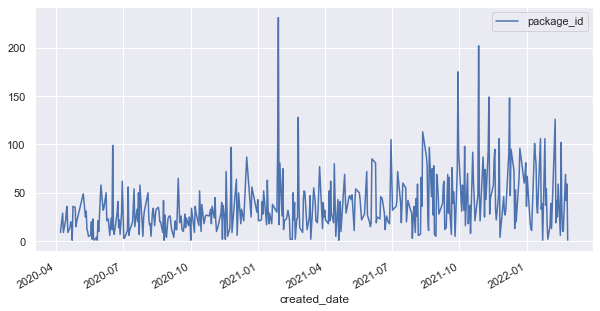

In [19]:
df_out_clean[['created_date','package_id']].groupby('created_date').count().plot()

In [30]:
max(df_out['created_date'])

Timestamp('2022-07-15 00:00:00')

In [20]:
df_out_clean.head()

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,received_quantity,received_unit_of_measure,receiver_wholesale_price,item_unit_weight,item_unit_weight_unit_of_measure_name
1785,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003133183,2022-02-25,2022-02-25 18:08:15+00:00,C11-0001146-LIC,LCISM CORP,C10-0000464-LIC,"UPROOTED, INC.",Wholesale Manifest,Wholesale,22604886,1A406030000F99E000310596,transfer,1A406030001E1A5000233133,"DKDS-M01221-F, DKDS-M10111-N, DKDS-M10201-G, D...",Accepted,False,False,Other Concentrate (weight - each),Level Hashtab Sativa,passed,117.0,10.0,Each,10.0,Each,117.0,1.75,Grams
1789,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003127591,2022-02-24,2022-02-24 17:45:16+00:00,C11-0001146-LIC,LCISM CORP,C10-0000464-LIC,"UPROOTED, INC.",Wholesale Manifest,Wholesale,22561468,1A406030000F99E000289415,transfer,1A406030001E1A5000222054,"#19, #20, #21, #22, #24, #25, #26, 0103SundaeD...",Accepted,False,False,Other Concentrate (weight - each),JETTY - Gold Cartridge GDP - 1000mg,passed,800.0,40.0,Each,40.0,Each,800.0,1.00,Grams
1790,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003127259,2022-02-24,2022-02-24 19:56:43+00:00,C11-0001146-LIC,LCISM CORP,C10-0000776-LIC,CALGEN TRADING INC.,Wholesale Manifest,Wholesale,22561186,1A406030000F99E000288106,transfer,1A406030001E1A5000231633,MVS101921WA,Accepted,False,False,Other Concentrate (weight - each),Nasha Green Powder Nigerian Haze WAK,passed,150.0,15.0,Each,15.0,Each,150.0,1.00,Grams
1791,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003127591,2022-02-24,2022-02-24 17:45:16+00:00,C11-0001146-LIC,LCISM CORP,C10-0000464-LIC,"UPROOTED, INC.",Wholesale Manifest,Wholesale,22561397,1A406030000F99E000289414,transfer,1A406030001E1A5000236631,"AVT F2 A, AVTF2B, AVTxDBC.1, AVTxDBC.2, Gary P...",Accepted,False,False,Other Concentrate (weight - each),JETTY - Gold Cartridge Gelato - 1000mg,passed,800.0,40.0,Each,40.0,Each,800.0,1.00,Grams
1792,OUTGOING_TO_PAYOR,C11-0001146-LIC,0003127269,2022-02-24,2022-02-24 19:56:11+00:00,C11-0001146-LIC,LCISM CORP,C10-0000776-LIC,CALGEN TRADING INC.,Wholesale Manifest,Wholesale,22561402,1A406030000F99E000288114,transfer,1A406030000F99E000271444,"1-Field3-ThreeBears-6-15-20, 2021.07.19-CCM10-...",Accepted,False,False,Pre-Roll Infused,AE El Blunto Silver Hash White Walker OG,passed,480.0,60.0,Each,60.0,Each,480.0,1.00,Grams


## a. payer churn

In [21]:
PC_START_DATE = '2020-01-01'
PC_END_DATE = '2022-06-01'
PC_MONTH_LIST = ['2022-03-01','2022-04-01','2022-05-01','2022-06-01']
PC_MONTH_END = PC_MONTH_LIST[-1]

In [25]:
def calculate_payer_churn(
    outgoing_df, pc_start_date, pc_end_date, pc_month_list,gb 
):

    outgoing_df["year_month"] = pd.to_datetime(
        outgoing_df["created_date"]
    ).dt.strftime("%Y-%m")
    
    pc = (
        outgoing_df[
            ["year_month", gb, "receiver_wholesale_price"]
        ]
        .groupby(["year_month", gb])
        .sum()
        .reset_index()
    )
    
    
    pc = pc.assign(year_month=lambda df: pd.to_datetime(df["year_month"]))

    pc_full = (
        (
            pc.groupby(gb).apply(
                lambda df: df.merge(
                    pd.Series(
                        None,
                        index=pd.date_range(
                            start=pc_start_date, end=pc_end_date, freq="MS"
                        ),
                        name="__place_holder",
                    ),
                    how="right",
                    left_on="year_month",
                    right_index=True,
                )
                .assign(
                    **{
                        "receiver_wholesale_price": lambda df_: df_.receiver_wholesale_price.fillna(
                            0
                        ),
                    }
                )
                .drop(["__place_holder", gb], axis=1)
            )
        )
        .reset_index()
        .drop(["level_1"], axis=1)
    ).round(2)

    rolling_4m_sum = pc_full.groupby(gb).apply(
        lambda df: df.set_index("year_month").sort_index().rolling(4).sum()
    )
    rolling_4m_sum.columns = ["rolling_4m_total_price"]
    facility_monthly_running_total = pc_full.groupby(gb).apply(
        lambda df: df.set_index("year_month")
        .sort_index()["receiver_wholesale_price"]
        .cumsum()
        .to_frame()
    )
    facility_monthly_running_total.columns = ["facility_running_total"]
    monthly_running_total = (
        facility_monthly_running_total.reset_index()
        .groupby("year_month")["facility_running_total"]
        .sum()
        .to_frame()
    )
    monthly_running_total.columns = ["monthly_running_total"]

    pc_result = (
        rolling_4m_sum.merge(
            facility_monthly_running_total,
            how="inner",
            left_index=True,
            right_index=True,
        )
        .reset_index()
        .merge(monthly_running_total, how="left", on="year_month")
    ).round(2)
    pc_result["%_total"] = (
        pc_result["facility_running_total"] / pc_result["monthly_running_total"]
    )
    pc_result["last_4m_active"] = pc_result["rolling_4m_total_price"] > 0
    pc_result["significant"] = pc_result["%_total"] > 0.001
    pc_result["measure"] = pc_result.apply(
        lambda row: "Active"
        if (row["last_4m_active"] & row["significant"])
        else ("Inactive" if row["significant"] else "Exclude"),
        axis=1,
    )
    # churn
    churn = (
        pc_result.groupby(["year_month"])
        .apply(lambda x: x[x["measure"] == "Inactive"]["%_total"].sum())
        .reset_index()
    )
    churn.columns = ["year_month", "%_inactive"]
    churn.index = churn.year_month

    # output vendor churn matrix
    pc_data = pc_full[pc_full["year_month"] <= pc_end_date]
    pc_data["year_month"] = pc_data["year_month"].astype(str)
    pc_matrix = pd.pivot_table(
        pc_data,
        values="receiver_wholesale_price",
        index=gb,
        columns="year_month",
        fill_value=0,
    ).reset_index()
    pc_matrix["facility_total"] = pc_matrix.sum(axis=1)
    pc_matrix["grand_total"] = pc_matrix["facility_total"].sum()
    pc_matrix["perc_total"] = pc_matrix["facility_total"] / pc_matrix["grand_total"]
    pc_matrix["last_4m_total"] = pc_matrix[pc_month_list].sum(axis=1)
    pc_matrix["last_4m_active"] = pc_matrix["last_4m_total"] > 0
    pc_matrix["significant"] = pc_matrix["perc_total"] > 0.001
    pc_matrix["measure"] = pc_matrix.apply(
        lambda row: "Active"
        if (row["last_4m_active"] & row["significant"])
        else ("Inactive" if row["significant"] else "Exclude"),
        axis=1,
    )
    return churn, pc_matrix

In [26]:
churn,pc_matrix = calculate_payer_churn(df_out_clean,PC_START_DATE,PC_END_DATE,PC_MONTH_LIST,"recipient_facility_name")


In [27]:
pc_matrix.sort_values(by = 'perc_total',ascending = False)

year_month,recipient_facility_name,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,facility_total,grand_total,perc_total,last_4m_total,last_4m_active,significant,measure
23,"ULBP, Inc.",0,0,0,75505.40,53942.40,161384.45,116239.87,120134.14,88074.56,62031.51,95378.19,144652.50,163417.04,175151.52,126113.83,219598.12,93064.60,148177.98,87102.10,39371.65,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1969339.86,6599872.29,0.298391,0,False,True,Inactive
7,"California Patients Alliance, Inc.",0,0,0,45420.60,42699.53,62424.00,49583.75,42678.54,55030.60,43861.65,46089.77,52276.19,38090.24,42295.19,50673.93,55334.11,41350.41,34147.17,33731.12,44119.77,38356.28,36002.87,37100.40,4830.00,0.00,1400.00,0,0,0,0,897496.12,6599872.29,0.135987,0,False,True,Inactive
22,"ULBP, INC.",0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21071.77,56647.37,66779.81,85707.58,83907.60,76503.29,68296.77,0,0,0,0,458914.19,6599872.29,0.069534,0,False,True,Inactive
8,California's Choice Collective,0,0,0,33891.00,31252.00,12905.20,13452.10,32056.00,20855.63,42401.50,23162.72,10781.60,44389.67,16330.16,30209.50,32379.63,11677.74,2420.00,0.00,0.00,0.00,0.00,0.00,0.00,5180.96,0.00,0,0,0,0,363345.41,6599872.29,0.055053,0,False,True,Inactive
6,"CALIMED MANAGEMENT GROUP, LLC",0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10492.96,0.00,65408.92,31363.30,22562.05,0.00,7407.12,37958.68,545.60,9468.50,36845.40,4642.50,31850.34,38394.38,16684.00,19296.00,0,0,0,0,332919.75,6599872.29,0.050443,0,False,True,Inactive
20,"THE MEDICINE WOMAN GROUP, LLC",0,0,0,7684.00,4504.56,18427.85,14927.50,13080.50,17951.00,19530.08,12513.60,18776.80,10327.93,14347.17,14816.31,13969.98,15771.28,20179.94,19738.84,15231.30,14326.36,10738.66,16692.07,0.00,17029.83,15030.58,0,0,0,0,325596.14,6599872.29,0.049334,0,False,True,Inactive
12,"HUENEME PATIENT CONSUMER COLLECTIVE, LLC.",0,0,0,13644.02,3857.00,22474.50,7308.03,21221.57,18872.87,7032.03,17835.91,13187.51,11921.81,15760.53,0.12,13951.51,21261.15,8754.10,9252.00,8794.03,0.00,15835.25,7864.85,7575.60,7324.08,8577.04,0,0,0,0,262305.51,6599872.29,0.039744,0,False,True,Inactive
26,"UPROOTED, INC.",0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3564.85,25331.70,23499.91,30929.40,49827.53,47834.84,24070.10,22556.65,0,0,0,0,227614.98,6599872.29,0.034488,0,False,True,Inactive
4,CALGEN TRADING INC.,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5306.37,25565.95,25268.23,38589.48,45048.79,36587.38,34596.13,0,0,0,0,210962.33,6599872.29,0.031965,0,False,True,Inactive
1,BANANA LLC,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6188.98,23851.12,24549.19,19464.12,51715.20,20464.73,29211.20,25982.45,0,0,0,0,201426.99,6599872.29,0.030520,0,False,True,Inactive


In [ ]:

pc_matrix[pc_matrix['recipient_facility_license_number'] == 'C10-0000279-LIC']

In [ ]:
in_data = df_in_ext_clean[['received_datetime','shipper_facility_license_number','shipper_facility_name',\
                            'shipment_type_name','package_id','product_name','shipped_quantity','received_quantity','received_unit_of_measure']]
in_data.columns = ['received_datetime_in','shipper_facility_license_number_in','shipper_facility_name_in',\
                            'shipment_type_name_in','package_id','product_name_in','shipped_quantity_in','received_quantity_in','received_unit_of_measure_in']

In [ ]:
out_data = df_out[['received_datetime',\
                      'recipient_facility_license_number','recipient_facility_name','package_id',\
                      'product_name','shipped_quantity','received_quantity','received_unit_of_measure']]
out_data.columns = ['received_datetime_out',\
                      'recipient_facility_license_number_out','recipient_facility_name_out','package_id',\
                      'product_name_out','shipped_quantity_out','received_quantity_out','received_unit_of_measure_out']


In [ ]:
j = in_data.merge(out_data,how = 'left',on = ['package_id'])

In [ ]:
j.shape

# Vendor churn

In [ ]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-05-01'
VC_MONTH_LIST = ['2022-02-01','2022-03-01','2022-04-01','2022-05-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [ ]:
license_numbers

In [ ]:
df_in['delivery_type'].unique()

In [ ]:
df_out.head()

In [ ]:
test_pkg

In [ ]:
df_in[df_in['package_id'] == '24408766']

In [ ]:
df_out[df_out['package_id'] == '24408766']

In [ ]:
test_pkg[(test_pkg['recipient_facility_name'].notnull())&(test_pkg['received_datetime_x'] < test_pkg['received_datetime_y'])]


In [ ]:
df_in[df_in['package_id'] == '24408766']

In [ ]:
df_out[df_out['package_id'] == '24408766']

In [ ]:
df_out[df_out['recipient_facility_license_number'] == 'C12-0000392-LIC']

In [ ]:
test_pkg[test_pkg['recipient_facility_name'].notnull()].shape[0] / test_pkg.shape[0]

In [ ]:
churn,vc_matrix = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)


In [ ]:
churn_short,vc_matrix_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


In [ ]:
churn_short

In [ ]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [ ]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


In [ ]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

In [ ]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


In [ ]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

# COGS analysis

In [ ]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [ ]:
df_summary_simp,df_cogs_average_product = client_surveillance_jupyter.cogs_analysis(df_in,df_sales,'monthly',company_state)


In [ ]:
df_summary_simp

In [ ]:
df_summary_simp_uom,df_cogs_average_product_uom = client_surveillance_jupyter.cogs_analysis_uom(df_in,df_sales,'monthly',company_state)


In [ ]:
j = df_sales.merge(df_in,how= 'left',left_on = 'tx_package_id',right_on = 'package_id')

In [ ]:
j[(j['tx_unit_of_measure']!= j['shipped_unit_of_measure'])&(j['shipped_unit_of_measure'].notnull())][['sales_month','tx_package_id','tx_product_name','tx_product_category_name','tx_unit_of_measure','shipped_unit_of_measure','per_unit','per_unit_incoming']].head()



In [ ]:
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(10,5)})

In [ ]:
df_summary_simp['margin_%'] - df_summary_simp_uom['margin_%']

In [ ]:
plt.scatter(df_summary_simp['margin_%'] ,df_summary_simp_uom['margin_%'] )
plt.xlabel('GM% original')
plt.ylabel('GM% improved')


In [ ]:
df_summary_simp[[ 'revenue', 'cogs', 'margin_$', 'margin_%']]

In [ ]:
df_summary_simp_uom[[ 'revenue', 'cogs', 'margin_$', 'margin_%']]

# Revenue change vs state

In [ ]:
if COMPANY_IDENTIFIER == ['NECC']:
    a = client_surveillance_jupyter.calculate_quarterly_sum_gmv_ma_short(df_summary_simp)
    a

In [ ]:
if COMPANY_IDENTIFIER == ['NECC']:
    round(a.dropna()['total'].sum(),2)

In [ ]:
a = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp)
round(a.dropna()['total'].sum(),2)

In [ ]:
a

# Inventory

In [ ]:
today = date.today()
today

In [ ]:
COMPANY_IDENTIFIER

In [ ]:
license_numbers

In [ ]:
df_inventory.head()

In [ ]:
df_in['created_date'] = pd.to_datetime(df_in['created_date'])

In [ ]:
df_in_recent

In [ ]:
df_in_recent = df_in[df_in['created_date'] >= '2022-01-01']

In [ ]:
df_in_recent.head()

In [ ]:
df_inventory['package_id'].nunique()

In [ ]:
df_inventory_license = client_surveillance_jupyter.calculate_inventory_valuation(df_in_recent,df_inventory,license_numbers,today)

In [ ]:
df_inventory_license

In [ ]:
df_inventory_license_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales,df_inventory,license_numbers,today)

In [ ]:
df_inventory_license_msrp

In [ ]:
df_inventory_fresh,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory,license_numbers,today,0,90)

In [ ]:
df_inventory_fresh

In [ ]:
_['age_int'].describe()

# Quantity based inventory TO

In [ ]:
df_inventory.head()

In [ ]:
inventory_q = df_inventory[['package_id','unit_of_measure','quantity']].groupby(['package_id','unit_of_measure']).sum()



In [ ]:
inventory_q = inventory_q.reset_index()
inventory_q

In [ ]:
df_sales_3m = df_sales[df_sales['sales_month'] >= '2022-03']

In [ ]:
sales_q = df_sales_3m[['tx_package_id','tx_unit_of_measure','tx_quantity_sold']].groupby(['tx_package_id','tx_unit_of_measure']).sum()
sales_q = sales_q.reset_index()


In [ ]:
j = inventory_q.merge(sales_q,how = 'left',left_on = ['package_id','unit_of_measure'],right_on = ['tx_package_id','tx_unit_of_measure'])



In [ ]:
j['to'] = j['tx_quantity_sold'] / j['quantity'] * 4

In [ ]:
j[j['to'] >= 50]

In [ ]:
j['to'].describe()

# Repayment score

In [ ]:
company_repayment_data

In [ ]:
company_repayment_data_due = company_repayment_data[company_repayment_data['adjusted_maturity_date'] < today]

In [ ]:
company_repayment_data_due


In [ ]:
company_repayment_data_due['weight'] = company_repayment_data_due['loan_amount'] / sum(company_repayment_data_due['loan_amount'])

In [ ]:
len(company_repayment_data_due)

In [ ]:
if len(company_repayment_data_due) == 0:
    weighted_dpd = numpy.nan
else:
    weighted_dpd = sum(company_repayment_data_due['days_late'] * company_repayment_data_due['weight'])

    

In [ ]:
weighted_dpd

In [ ]:
repayment_score = client_surveillance_jupyter.get_short_repayment_score(weighted_dpd)
repayment_score

# Create Template: updated

In [ ]:
current_month = '2022-05'
full_score = 45

In [ ]:
license_numbers

In [ ]:
template_new_ = client_surveillance_jupyter.create_template_update(a,df_summary_simp,df_inventory_license,df_inventory_license_msrp,df_inventory_fresh,churn_short,retial_license_check_df,license_numbers,company_state,current_month)



In [ ]:
template_new_

# Output data 

In [ ]:
license_numbers

## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



In [ ]:
# multiple licenses
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today)  +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')
#retial_license_check_df



# Appendix

In [ ]:
# def calculate_quarterly_sum_gmv_ma_short(cogs_analysis_df):

#     gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
#     gmv_df['sum_gmv_change_ma'] = [-0.07,0.09,-0.11,0.02]
#     gmv_df['weight'] = [0.76,0.84,0.92,1]
#     gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
#     gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
#     gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
#     gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
#     return gmv_df
    